In [1]:
import tensorflow as tf
import tensorflow.keras as tfk
import numpy as np
from matplotlib import pyplot as plt

In [2]:
(x_train_full, y_train_full), (x_test_full, y_test_full) = tfk.datasets.mnist.load_data()

In [65]:
as_rgb = lambda im: np.tile(np.expand_dims(im,2),(1,1,3))

print('data tensor: %s ' % str(x_train_full.shape))
print('individual image size: %s' % str(x_train_full[0,:,:].shape))

data tensor: (60000, 28, 28) 
individual image size: (28, 28)


## Take a random subsample of MNIST 2s and 4s

In [4]:
N = 100 # how much data of each class
c1, c2 = 2, 4 # these are our two classes for binary classification

##### Training data
We use N = 100 of each class

This code takes a random choice of N images from each class (`c1`,`c2`) and constructs a subsample `200x28x28`.

In [5]:
index_of_c1 = np.argwhere(y_train_full == c1).ravel() # index of 2s
index_of_c1 = np.random.choice(index_of_c1, N, replace=False)

index_of_c2 = np.argwhere(y_train_full == c2).ravel()# index of 4s
index_of_c2 = np.random.choice(index_of_c2, N, replace=False)

x_train = x_train_full[np.hstack((index_of_c1, index_of_c2))] # subsample
y_train = y_train_full[np.hstack((index_of_c1, index_of_c2))] # subsample

We want to resize the data, so we use the tensorflow `resize_images` utility. This is a delayed evaluation, as we will use TensorFlow's [static graph computation](https://www.tensorflow.org/guide/graphs).

Essentially, for each image in `x_train`, we duplicate it to create an RGB version of the image `(28x28x3)`, and then pass to `resize_images`. This results in a `299x299x3` Tensor (which will become an image when we evaluate it with `tf.Session()`). We combine all images into a batch tensor by stacking them along the first dimension.

In [6]:
train_rs = tf.concat(
    [
        tf.expand_dims(
            tf.image.resize_images(
                as_rgb(x_train[i,:,:]),
                (299,299),
                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
            ),
        0) for i in range(x_train.shape[0])
    ],
    0
)
print(train_rs) # batch tensor of RGB images (this has not been evaluated yet)

Tensor("concat:0", shape=(200, 299, 299, 3), dtype=uint8)


##### Test Data
We now do the same but for the test data

In [7]:
index_of_c1 = np.argwhere(y_test_full == c1).ravel() # index of 2s
index_of_c1 = np.random.choice(index_of_c1, N, replace=False)

index_of_c2 = np.argwhere(y_test_full == c2).ravel() # index of 2s
index_of_c2 = np.random.choice(index_of_c2, N, replace=False)

x_test = x_test_full[np.hstack((index_of_c1, index_of_c2))]
y_test = y_test_full[np.hstack((index_of_c1, index_of_c2))]

In [8]:
test_rs = tf.concat(
    [
        tf.expand_dims(
            tf.image.resize_images(
                as_rgb(x_test[i,:,:]),
                (299,299),
                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
            ),0) for i in range(x_test.shape[0])
    ],
    0
)
print(test_rs) # batch tensor of RGB images (this has not been evaluated yet)

Tensor("concat_1:0", shape=(200, 299, 299, 3), dtype=uint8)


### Evaluating the reshape operation

**Using TensorFlow may not be the best way to do image resizing, I'm just using it because I already have it loaded, and I can give you an example of how `tf.Session().run()` works**

In [9]:
# We create a Session instance to execute tensors
#    sess is a Session, but only exists within the `with` block
#    this prevents memory overload by running too many sessions
with tf.Session() as sess:
    # The first thing that must be done is initialising tensors (ESSENTIAL)
    sess.run(tf.global_variables_initializer())
    # Applying sess.run() to a tensor, e.g. x_resze, will evaluate it and
    #    return the numpy version
    new_x_train = sess.run(train_rs)
    new_x_test  = sess.run(test_rs)
# we could optionally chain all calls to sess.run in one command, e.g.
# _, new_x_train, new_x_test = sess.run([tf.global_variables_initializer(), train_rs, test_rs])

In [10]:
print(new_x_train.shape)
print(new_x_test.shape)

(200, 299, 299, 3)
(200, 299, 299, 3)


### Plot results of resizing
You can rerun the following cell and it will get a new image from the training data and test data

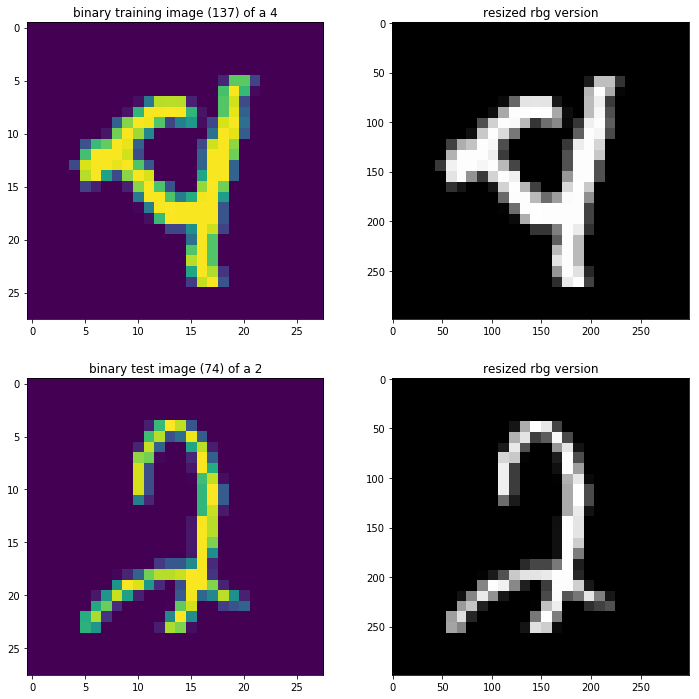

In [11]:
plt.figure(figsize=(12,12))
i = np.random.randint(0, new_x_train.shape[0])
plt.subplot(221)
plt.imshow(x_train[i,:,:])
plt.title("binary training image (%d) of a %d" % (i,y_train[i]))
plt.subplot(222)
plt.imshow(new_x_train[i,:,:])
plt.title("resized rbg version");

i = np.random.randint(0, new_x_test.shape[0])
plt.subplot(223)
plt.imshow(x_test[i,:,:])
plt.title("binary test image (%d) of a %d" % (i,y_test[i]))
plt.subplot(224)
plt.imshow(new_x_test[i,:,:])
plt.title("resized rbg version");

### Inception

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [15]:
inception = InceptionV3(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(299,299,3)
)

87916544/87910968 [==============================] - 40s 0us/step


### Feature Extraction

We use the `inception` model to get feature vectors:

In [20]:
training_features = inception.predict(new_x_train)
print(training_features.shape)

(200, 2048)


In [25]:
test_features = inception.predict(new_x_test)
print(test_features.shape)

[[ 2.8140774  15.070626    1.2605075  ...  1.6774261   0.
   0.9187352 ]
 [ 0.28050423  1.0672438   0.         ...  1.112262    0.
   0.31243774]
 [ 4.9687753   1.7053828   0.         ...  1.5006678   0.
   0.59142035]
 ...
 [ 0.30219156  6.8252687   0.99834985 ...  3.4056268   0.
   0.16800255]
 [ 2.2189844   3.573133    0.         ...  0.          0.
   0.        ]
 [ 0.         16.82864     0.         ...  0.          0.
   0.        ]]


### Classification

In [23]:
from sklearn.linear_model import SGDClassifier as Classifier

In [24]:
clf = Classifier(max_iter=1000, tol=1e-3)

clf.fit(training_features, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [30]:
y_predict = clf.predict(test_features)

In [62]:
acc = clf.score(test_features, y_train)
print("accuracy: %f" % acc)
print("successfully classified: %d/%d" %( np.sum(y_predict == y_train), len(y_train)))

accuracy: 0.935000
successfully classified: 187/200


#### Show failed classification

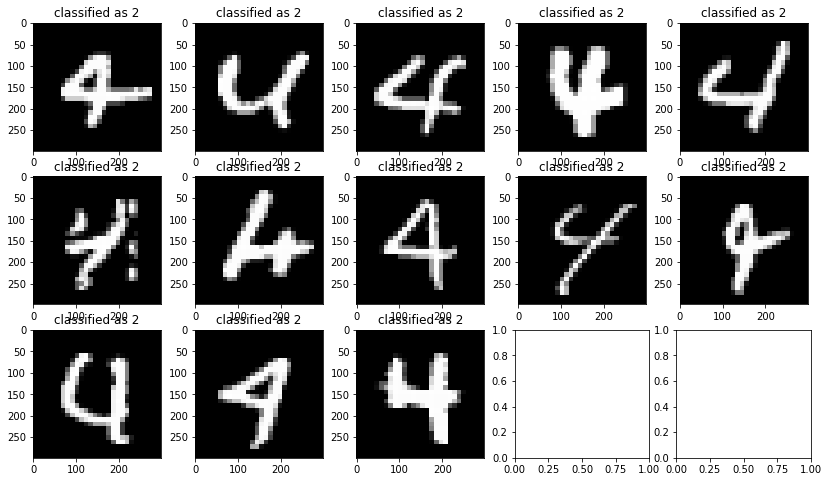

In [59]:
ix, = np.where(y_predict != y_train)

nc = 5
nr = int(np.ceil(len(ix) / nc))

fig, axs = plt.subplots(nr,nc, figsize=(14,8))
axs = axs.ravel()
for k,i in enumerate(ix):
    axs[k].imshow(new_x_test[i,:,:])
    axs[k].title.set_text("classified as %d" % y_predict[i])